# Model Training & Evaluation

* This note book is similar to `02_training_evaluation_colab` the only difference is we've created this to run locally instead of on `Google Colab`. The main reason for this is that the free version of `Google Colab` only has 2 cores, while our local machine has 12 cores giving us added advantage of almost 2X performance. 

## Import Libraries

In [1]:
from sklearn.preprocessing import Binarizer, OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from pathlib import Path


from sklearn.metrics import ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.dummy import DummyClassifier


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import joblib
import json
import gdown



## Read Data

In [2]:
## function to download data from google drive
def download_from_google_drive(file_id, file_name):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, file_name, quiet=False)

In [3]:
## check if mnist data is already downloaded
mnist_train_set_path = Path("..", "data", "mnist_train_set.csv")
mnist_test_set_path = Path("..", "data", "mnist_test_set.csv")

if not mnist_train_set_path.exists():
    ## download train set
    file_id = "1Rho1umzwBQTodR7sXVCdUZsJE7xq9EmM"
    # data_dir = str(Path("..", "data", "mnist_train_set.csv"))
    download_from_google_drive(file_id, str(mnist_train_set_path))

if not mnist_test_set_path.exists():
    ## download test set
    file_id = "1qxd-M96DJpYXHfO8xf_XKdDHr3o0xMUE"
    # data_dir = str(Path("..", "data", "mnist_test_set.csv"))
    download_from_google_drive(file_id, str(mnist_test_set_path))

### Access Train/Test Data

In [4]:
## access train data
mnist_train_set = pd.read_csv(mnist_train_set_path)

## access test data
mnist_test_set = pd.read_csv(mnist_test_set_path)

In [5]:
mnist_train_set.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
mnist_test_set.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


### Split Features/Target Dataset

In [7]:
## Split training features and target into separate dataset
train_X = mnist_train_set.drop("class", axis=1)
train_Y = mnist_train_set["class"]

## split test features and target into separate dataset
test_X = mnist_test_set.drop("class", axis=1)
test_Y = mnist_test_set["class"]

In [8]:
train_X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 335.0 MB


In [10]:
train_Y.head()

0    0
1    7
2    0
3    9
4    1
Name: class, dtype: int64

In [11]:
train_Y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 56000 entries, 0 to 55999
Series name: class
Non-Null Count  Dtype
--------------  -----
56000 non-null  int64
dtypes: int64(1)
memory usage: 437.6 KB


In [12]:
test_X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 83.7 MB


In [14]:
test_Y.head()

0    7
1    3
2    1
3    1
4    2
Name: class, dtype: int64

In [15]:
test_Y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 14000 entries, 0 to 13999
Series name: class
Non-Null Count  Dtype
--------------  -----
14000 non-null  int64
dtypes: int64(1)
memory usage: 109.5 KB


## Data Transformation

* Based on `Data Exploration` done in [01_explore_data.ipynb](https://github.com/gaurangdave/mnist_digits_recognition/blob/main/notebooks/01_explore_data.ipynb) below is the outline of the pipeline we are going to create,
  * Pipeline Parameters
    * `method` - To indicate whether we are going to `normalize`, `binarize` or leave the data as it is `none`.
    * `threshold` - only applicable to `binarize` option to help set the threshold for binarization.

### Preprocessing Function

In [16]:
def preprocess_data(data, method="none", threshold = 128):
    """
    Preprocess MNIST data based on the specified method.

    Args:
        data (pd.DataFrame): Input dataset with only features.
        method (str): Preprocessing method - "normalize", "binarize", or "none".

    Returns:
        pd.DataFrame: Preprocessed dataset.
    """
    if method == "normalize":
        scaler = MinMaxScaler()
        transformed_data = scaler.fit_transform(data)
        return pd.DataFrame(transformed_data)
    elif method == "binarize":
        binarizer = Binarizer(threshold=threshold)
        transformed_data = binarizer.fit_transform(data)
        return pd.DataFrame(transformed_data)
    # else, keep features unchanged (no transformation)

    # Combine processed features and labels
    return pd.DataFrame(data)

* Lets create a `FunctionalTransformer` and test the pipeline

In [17]:
## helper function to print aggregated descrition of features
def print_aggregated_description(data):
  # Check the range of normalized pixel values
  print(f"Min of mins in data is {data.iloc[:, :].min().min()} and max of mins in data is {data.iloc[:, :].min().max()}")
  print(f"Min of max in data is {data.iloc[:, :].max().min()} and max of max in data is {data.iloc[:, :].max().max()}")

  # # Check the mean and standard deviation
  print(f"Aggregated mean of data is {data.iloc[:, :].mean().mean()}")
  print(f"Aggregated standard deviation of data is {data.iloc[:, :].std().mean()}")


In [18]:
preprocess_transformer = FunctionTransformer(preprocess_data, feature_names_out="one-to-one")


In [19]:
## this should output the dataframe as it is without any changes.
preprocessed_data = pd.DataFrame(preprocess_transformer.fit_transform(train_X, y=None), columns=preprocess_transformer.get_feature_names_out())
print_aggregated_description(preprocessed_data)

Min of mins in data is 0 and max of mins in data is 0
Min of max in data is 0 and max of max in data is 255
Aggregated mean of data is 33.40283570973032
Aggregated standard deviation of data is 49.25044784975305


Observation:
* Here aggregated min is 0 and max is 255 which matches the raw data as expected and aggreagated mean and standard deviation also matches the raw data as expected

In [20]:
## this should normalized the dataframe.
preprocess_transformer = FunctionTransformer(preprocess_data, kw_args={"method": "normalize"}, feature_names_out="one-to-one")
preprocessed_data = pd.DataFrame(preprocess_transformer.fit_transform(train_X), columns=preprocess_transformer.get_feature_names_out())
print_aggregated_description(preprocessed_data)

Min of mins in data is 0.0 and max of mins in data is 0.0
Min of max in data is 0.0 and max of max in data is 1.0
Aggregated mean of data is 0.13099372795196987
Aggregated standard deviation of data is 0.19343918583584427


In [21]:
## this should binarize the dataframe.
preprocess_transformer = FunctionTransformer(preprocess_data, kw_args={"method": "binarize", "threshold": 128}, feature_names_out="one-to-one")
preprocessed_data = pd.DataFrame(preprocess_transformer.fit_transform(train_X), columns=preprocess_transformer.get_feature_names_out())
print_aggregated_description(preprocessed_data)

Min of mins in data is 0 and max of mins in data is 0
Min of max in data is 0 and max of max in data is 1
Aggregated mean of data is 0.13101193513119536
Aggregated standard deviation of data is 0.21739390727945354


## Plan

* As a learning experience, we've decided to explore the following ML Algorithms to explore for classification,
  1. Logistic Regression.
  1. Support Vector Classifier (SVC).
  1. K-Nearest Neighbour.
  1. Random Forest Classifier.
* We'll use the following metrics for each model,
  * Accuracy
  * Weighted F1 Score
  * Per-class F1 Score
* For `Logistic Regression` and `SVC` we'll focus on `hyperparameter tuning` and `threshold tuning` to get the best results.
* For `KNN` and `Random Forest Classifier` we'll just focus on `hyperparameter tuning` to reduce the complexity and focus on getting handson experience with what we've learnt so far.
* For all algorithms we'll do the following,
  * Find a baseline model using cross validation
  * Find hyper params using grid search cv
    * Get the metrics for hypertuned model using cross validation for apples to apples comparison between baseline and hypertuned.
* We need to do cross validation again for hypertuned model because once the hyper params are discovered, grid search cv trains a model on complete training data. And so when we calculate the performance metrics these numbers are inflated since model has already seen the data.
  * To do the right comparison we either need to have a unseen validation set or use the hyper parameters in cross validation to get the right numbers.  For now we've decided to go with cross validation.

## Baseline Model

* Lets create models using `DummyClassifier` with stratified and most frequest strategies to create a baseline for comparison

### Stratified Classifier

In [22]:
# Create a dummy classifier that predicts randomly based on class distribution
dummy_stratified = DummyClassifier(strategy="stratified", random_state=42)
dummy_stratified.fit(train_X, train_Y)

# Predict and evaluate
stratified_predictions = dummy_stratified.predict(test_X)
stratified_accuracy = accuracy_score(test_Y, stratified_predictions)
stratified_f1 = f1_score(test_Y, stratified_predictions, average="weighted")
print(f"Stratified Prediction - Accuracy: {stratified_accuracy:.4f}")
print(f"Weighted F1: {stratified_f1:.4f}")

Stratified Prediction - Accuracy: 0.0988
Weighted F1: 0.0988


### Most Frequest Classifier

In [23]:
# Create a dummy classifier that predicts the most frequent class
dummy_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_most_frequent.fit(train_X, train_Y)

# Predict and evaluate
most_frequent_predictions = dummy_most_frequent.predict(test_X)
most_frequent_accuracy = accuracy_score(test_Y, most_frequent_predictions)
most_frequent_f1 = f1_score(test_Y, most_frequent_predictions, average="weighted")
print(f"Most Frequent Class - Accuracy: {most_frequent_accuracy:.4f}")
print(f"Weighted F1: {most_frequent_f1:.4f}")

Most Frequent Class - Accuracy: 0.1125
Weighted F1: 0.0228


### Summary

In [24]:
baseline_results = pd.DataFrame({
    "Model": ["Most Frequent", "Stratified"],
    "Accuracy": [most_frequent_accuracy, stratified_accuracy],
    "Weighted F1": [most_frequent_f1, stratified_f1]
})

baseline_results

,Model,Accuracy,Weighted F1
0,Most Frequent,0.112500,0.022753
1,Stratified,0.098786,0.098806


### Observations
* Both baseline models have very low `F1 Score` and `Accuracy` as expected.
* Since the train and test set were stratified, the frequency of classes in both the sets are more or less similar which explains why the accuracy of `Frequent Dummy Classifier` is more than `Stratified`.

## Helper Functions

In [25]:
## helper function to calculate per class f1 scores
def per_class_f1_score(actual_classes, prediction_classes):
    # Compute F1 scores for each class directly
    f1_scores = f1_score(actual_classes, prediction_classes, average=None)
    # Create a list of dictionaries for output
    per_class_f1_scores = [{"class": i, "f1_score": score} for i, score in enumerate(f1_scores)]

    return per_class_f1_scores

In [34]:
def update_model_comparison(probabilities, true_labels, algorithm, method, filename, comparison_df=None):
    """
    Updates the model comparison DataFrame with metrics for a given model.

    Args:
        probabilities (ndarray): Probabilities or predicted values for the dataset.
        true_labels (Series or ndarray): True labels for the dataset.
        algorithm (str): Name of the algorithm (e.g., 'Logistic Regression').
        method (str): Method used (e.g., 'Default Params', 'Grid Search').
        filename (str): Name of the file to save the model.
        comparison_df (DataFrame or None): Existing comparison DataFrame. If None, a new one is created.

    Returns:
        DataFrame: Updated comparison DataFrame with metrics for the given model.
    """

    # Get predicted classes (argmax for probabilities)
    predicted_classes = probabilities.argmax(axis=1)

    # Compute metrics
    accuracy = accuracy_score(true_labels, predicted_classes)
    weighted_f1 = f1_score(true_labels, predicted_classes, average='weighted')
    roc_score = roc_auc_score(train_Y, probabilities, multi_class="ovr")
    # Compute per-class F1 scores
    per_class_f1_scores = f1_score(true_labels, predicted_classes, average=None)
    per_class_f1_dict = {f"Class_{i}": score for i, score in enumerate(per_class_f1_scores)}

    # Create a new row with metrics
    new_row = {
        "Algorithm": algorithm,
        "Method": method,
        "File Name": filename,
        "Accuracy": accuracy,
        "Weighted F1 Score": weighted_f1,
        "ROC AUC Score": roc_score,
        **per_class_f1_dict,  # Unpack per-class F1 scores
    }

    # Initialize or update the DataFrame
    if comparison_df is None:
      return pd.DataFrame([new_row])


    # Append the new row
    comparison_df = pd.concat([comparison_df, pd.DataFrame([new_row])], ignore_index=True)

    return comparison_df

In [27]:
## helper function to save the model metrics to google drive
models_path = Path("..", "models")
def save_comparison_df(comparison_df):
  comparison_df.to_csv(f"{str(models_path)}/mnist_models_metrics.csv", index=False)


In [28]:
## helper function to dump and save the model on google drive
from joblib import dump
def save_model(estimator, file_name):
  ## model path
  model_path = Path("..", "models", file_name)
  dump(estimator, str(model_path))

## Logistic Regression

* Lets start with default estimator in logistic regression, we'll analyze the performance, tune the threshold and get the final performance numbers
* After that we'll experiment with hyperparameters using `GridSearchCV` and `RandomSearchCV` tune the threshold

### Default Estimator

#### Initialize Pipeline

In [29]:
from sklearn.linear_model import LogisticRegression

## initialize LogisticRegression
logistic_regression = LogisticRegression(max_iter=10000)

## create pipeline
default_pipeline = Pipeline([
    ("preprocessing", FunctionTransformer(preprocess_data, kw_args={"method": "normalize"})),
    ("training", logistic_regression)
])

#### Finding Probabilies

In [30]:
probabilities = cross_val_predict(default_pipeline, train_X, train_Y, cv=3, method="predict_proba", n_jobs=-1)

In [31]:
probabilities

array([[9.98539849e-01, 1.72487179e-17, 3.04786440e-08, ...,
        8.46459391e-11, 1.14099141e-09, 1.56510674e-11],
       [2.17677175e-11, 8.05965604e-05, 2.73645806e-06, ...,
        9.96868621e-01, 6.65571635e-04, 2.29046998e-03],
       [9.99287289e-01, 3.93336806e-12, 2.53542609e-05, ...,
        2.36146724e-06, 3.75609944e-05, 2.72536315e-04],
       ...,
       [1.34196753e-10, 9.94951280e-01, 6.46942453e-05, ...,
        4.78412044e-06, 2.28747392e-03, 2.65979418e-04],
       [2.62376595e-08, 1.57345691e-08, 4.04014881e-05, ...,
        1.51480874e-03, 4.64608394e-03, 9.77021388e-01],
       [1.07720256e-07, 2.95387863e-06, 5.60961756e-05, ...,
        2.72198097e-01, 1.98544675e-03, 6.64139264e-02]])

#### Save Model

In [32]:
# Train on the entire training dataset
default_pipeline.fit(train_X, train_Y)

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function preprocess_data at 0x17b9eeb60>,
                                     kw_args={'method': 'normalize'})),
                ('training', LogisticRegression(max_iter=10000))])

In [33]:
## save the model
save_model(default_pipeline, "logistic_regression_v0.joblib")

#### Performance Metrics

In [35]:
## create/update comparison_df to compare metrics from all the models.
comparison_df = update_model_comparison(probabilities, train_Y, "Logistic Regression V0", "Default Estimator", "logistic_regression_v0.joblib")

In [36]:
comparison_df

,Algorithm,Method,File Name,Accuracy,Weighted F1 Score,ROC AUC Score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,Logistic Regression V0,Default Estimator,logistic_regression_v0.joblib,0.919839,0.919697,0.992891,0.96094,0.964241,0.904483,0.898339,0.926959,0.879824,0.944259,0.929785,0.880834,0.897883


In [37]:
save_comparison_df(comparison_df)

Observations:
* `ROC AUC Score` of ~.99 means our estimator has high `True Positive Rate (TPR)` and a very low `False Positive Rate (FPR)`
  * i.e. The model has very accurate discrimination rate between different classes
* `F1 Score` of ~0.92 is a descent score, but this also tells us that our model has a low `Recall` i.e it has a higher `False Negative` rate.
* Per class f1 score tells us that f1 score of class instance of 3, 5 8 and 9 is significantly lower than rest of classes and these might have an impact of overall f1 score.
* Lets take a look at confusion matrix before threshold tuning

#### Confusion Matrix

* Lets look at normalized data in percentage to get more useful insight

In [38]:
predictions = np.argmax(probabilities, axis=1)

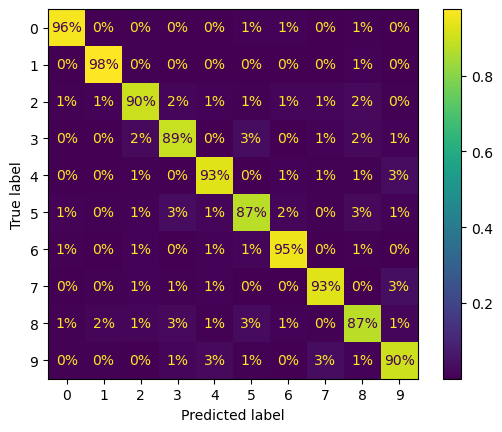

In [39]:
ConfusionMatrixDisplay.from_predictions(train_Y, predictions, normalize="true", values_format=".0%")

Observations:
* So the percent of predictions for `3`, `5` and `8` are significantly less than rest of the classes as expected
* Which is interesting because when it comes to hand written digits, `3`, `5` and `8` are similar and can be confusing depending on the handwriting.
* Lets focus more on errors by putting 0 weight on correct predictions

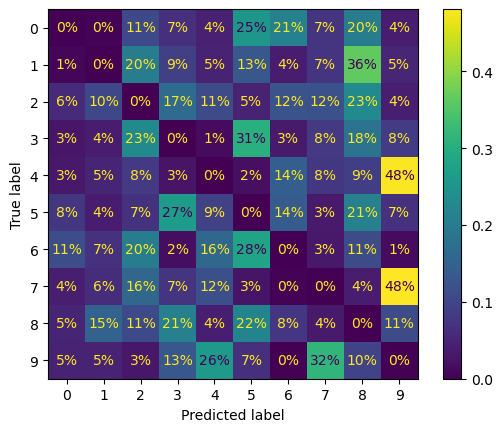

In [40]:
sample_weight = (predictions != train_Y)
ConfusionMatrixDisplay.from_predictions(train_Y, predictions, normalize="true", values_format=".0%", sample_weight=sample_weight)

Observations:
* This is interesting, this confusion matrix highlights some interesting chunks of errors,
  * `47%` of errors of 4 (False Negatives) and `48%` of errors of 7 were classified as 9. This kind of makes sense, cause when we write 4 or 7 its kind of similar to 9. The straight line of 7 or angle of 4 can be mis represented as curve of 9.
  * Also majoriy of misclassified 3s are classified as 2, 5 and 8.
  * Similarly majority of misclassified 5s are classified as 3 and 8 and majority of 8s are misclassified as 3 and 5.
  * This makes sense cause hand written 2,3,5 and 8 share similar patterns.

#### Threshold Tuning

* Lets see if we can find a better threshold and improve the results.

##### Per Class Threshold Calculation

In [41]:
from sklearn.metrics import roc_curve

def calculate_per_class_threshold(actual_classes, prediction_probabilities):
    thresholds = []
    for class_label in range(10):  # Loop through all classes
        # Convert actual_classes to binary labels for the current class
        binary_labels = (actual_classes == class_label).astype(int)
        # Extract probabilities for the current class
        class_probabilities = prediction_probabilities[:, class_label]

        # Calculate ROC curve
        fpr, tpr, threshold = roc_curve(binary_labels, class_probabilities)

        # Calculate F1 scores for each threshold
        f1_scores = (2 * tpr * (1 - fpr)) / (tpr + (1 - fpr))

        # Handle any division by zero or invalid values in F1 scores
        f1_scores = np.nan_to_num(f1_scores)

        # Find the threshold with the highest F1 score
        optimal_idx = f1_scores.argmax()
        optimal_threshold = threshold[optimal_idx]

        # Store the threshold for this class
        thresholds.append({ "class": class_label, "optimal_threshold" : optimal_threshold})

    return thresholds

In [42]:
# Assuming `train_Y` contains actual class labels and `probabilities` contains class probabilities
thresholds = calculate_per_class_threshold(train_Y, probabilities)
threshold_df = pd.DataFrame(thresholds)

##### Predictions With Thresholds

In [43]:
## helper functions to predict using optimized thresholds
def predict_with_thresholds(prediction_probabilities, thresholds):
    predictions = []
    for i in range(prediction_probabilities.shape[0]):  # Iterate over each sample
        # Check if probabilities exceed their respective thresholds
        class_probs = [(cls, prob) for cls, prob in enumerate(prediction_probabilities[i]) if prob >= thresholds[thresholds["class"] == cls]["optimal_threshold"].values[0]]

        if class_probs:
            # Choose the class with the highest probability among those exceeding thresholds
            predictions.append(max(class_probs, key=lambda x: x[1])[0])
        else:
            # If no class exceeds threshold, default to the one with the highest probability
            predictions.append(prediction_probabilities[i].argmax())

    return np.array(predictions)

In [46]:
optimized_predictions = predict_with_thresholds(probabilities, thresholds=threshold_df)

In [47]:
f1_score(train_Y, optimized_predictions, average="weighted")

0.9196967787148708

* Original `f1 score` was `0.9197076517400227` so no change there.

### Hyperparameter Tuning

* For `Hyperparameter Tuning` we'll use the following strategy
  * Iteration 1 : First we'll experiment with different solvers [‘newton-cg’, ‘sag’, ‘saga’, ‘lbfgs’] and different transformation techniqune ['normalization', 'binarization']
  * Iteration 2 : Next along with above params we'll add penalty ['l2', 'None'] since `l2` works with all solvers we'll experiment with and without penalty, along with C [0.01, 0.1, 1, 10, 100]

#### Iteration 1

In [48]:
param_grid = {
    "logisticregression__solver": ["newton-cg", "sag", "saga", "lbfgs"],
    "preprocessing__kw_args": [{"method": "normalize"}, {"method": "binarize"}],
}

## initialize LogisticRegression
logistic_regression = LogisticRegression(max_iter=10000, verbose=1)

## create pipeline
pipeline = Pipeline([
    ("preprocessing", FunctionTransformer(preprocess_data, kw_args={"method": "normalize"})),
    ("logisticregression", logistic_regression)
])

In [49]:
# Grid search with your pipeline
## commenting these lines to avoid running fit again as it is time consuming.
## uncomment the below lines to fit model again.

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1, verbose=1)
grid_search.fit(train_X, train_Y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.0641773902393036 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06772560469289908 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06745058123962074 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06401940563544949 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06750060268395257 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.05596280984522609 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06405625109635646 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.05424221012737024 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.054371692338912696 <= 0.0001 False
Newton-CG iter = 1
  C

 This problem is unconstrained.


Epoch 240, change: 0.00053617
Epoch 239, change: 0.00065967
Epoch 273, change: 0.00017586
Epoch 241, change: 0.00081557
Epoch 270, change: 0.00014205
convergence after 270 epochs took 286 seconds
Epoch 240, change: 0.00056818
Epoch 242, change: 0.00091480
Epoch 274, change: 0.00013495
Epoch 240, change: 0.00046896
Epoch 273, change: 0.00012799
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7850     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+00    |proj g|=  6.41774D-02
Epoch 274, change: 0.00017314
Epoch 241, change: 0.00053252


 This problem is unconstrained.


Epoch 240, change: 0.00065463
Epoch 242, change: 0.00080944
Epoch 271, change: 0.00014022
Epoch 241, change: 0.00056346
Epoch 241, change: 0.00046414
Epoch 275, change: 0.00013318
Epoch 243, change: 0.00090787
Epoch 274, change: 0.00012626
Epoch 275, change: 0.00017043
Epoch 242, change: 0.00052887
Epoch 241, change: 0.00064941
Epoch 242, change: 0.00046045
Epoch 272, change: 0.00013843
Epoch 243, change: 0.00080348
Epoch 276, change: 0.00013143
Epoch 242, change: 0.00055996
Epoch 244, change: 0.00089832
Epoch 276, change: 0.00016799
Epoch 275, change: 0.00012455
Epoch 243, change: 0.00045589
Epoch 243, change: 0.00052527
Epoch 273, change: 0.00013665
Epoch 242, change: 0.00064369
Epoch 244, change: 0.00079720
Epoch 277, change: 0.00012968
Epoch 243, change: 0.00055568
Epoch 277, change: 0.00016551
Epoch 245, change: 0.00089244
Epoch 276, change: 0.00012287
Epoch 244, change: 0.00045140

At iterate   50    f=  2.48657D-01    |proj g|=  8.58704D-04
Epoch 274, change: 0.00013490
Epoch 24

 This problem is unconstrained.


Epoch 259, change: 0.00049351
Epoch 262, change: 0.00039434
Epoch 296, change: 0.00012545
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7850     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+00    |proj g|=  6.77256D-02
Epoch 295, change: 0.00010176


 This problem is unconstrained.


Epoch 262, change: 0.00076297
Epoch 291, change: 0.00010837
Epoch 261, change: 0.00070018
Epoch 260, change: 0.00046756
Epoch 259, change: 0.00055188
Epoch 260, change: 0.00048980
Epoch 263, change: 0.00039149
Epoch 297, change: 0.00012350

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 7850    225    240      1     0     0   9.598D-05   2.189D-01
  F =  0.21886837990007435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Epoch 296, change: 0.00010039
Epoch 292, change: 0.00010698
Epoch 262, change: 0.00069516
Epoch 263, change: 0.00075462
Epoch 261, change: 0.00046433
RUNNING THE L-BFGS-B CODE

      

 This problem is unconstrained.


Epoch 261, change: 0.00048573
Epoch 264, change: 0.00038859
convergence after 297 epochs took 311 seconds
Epoch 263, change: 0.00068942
Epoch 262, change: 0.00046118
Epoch 293, change: 0.00010562
Epoch 264, change: 0.00074972
Epoch 299, change: 0.00011998
Epoch 261, change: 0.00054245
Epoch 262, change: 0.00048279
Epoch 265, change: 0.00038578
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         7850     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30259D+00    |proj g|=  6.74506D-02


 This problem is unconstrained.


Epoch 264, change: 0.00068495
Epoch 263, change: 0.00045806
Epoch 294, change: 0.00010426

At iterate   50    f=  2.57646D-01    |proj g|=  2.05869D-03
Epoch 265, change: 0.00074191
Epoch 300, change: 0.00011830
Epoch 266, change: 0.00038298
Epoch 262, change: 0.00053816
Epoch 263, change: 0.00047945
Epoch 265, change: 0.00068019
Epoch 295, change: 0.00010293
Epoch 264, change: 0.00045492

At iterate   50    f=  2.51174D-01    |proj g|=  8.43499D-04
Epoch 266, change: 0.00073668
Epoch 301, change: 0.00011652
Epoch 267, change: 0.00038020
Epoch 263, change: 0.00053326
Epoch 264, change: 0.00047629
Epoch 266, change: 0.00067449
Epoch 296, change: 0.00010161
Epoch 268, change: 0.00037744
Epoch 265, change: 0.00045183
Epoch 302, change: 0.00011480
Epoch 267, change: 0.00072672
Epoch 264, change: 0.00052877
Epoch 265, change: 0.00047218

At iterate   50    f=  2.51098D-01    |proj g|=  1.17335D-03
Epoch 269, change: 0.00037471
Epoch 267, change: 0.00066911
Epoch 297, change: 0.00010031
Epoc

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        FunctionTransformer(func=<function preprocess_data at 0x17b9eeb60>,
                                                            kw_args={'method': 'normalize'})),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000,
                                                           verbose=1))]),
             n_jobs=-1,
             param_grid={'logisticregression__solver': ['newton-cg', 'sag',
                                                        'saga', 'lbfgs'],
                         'preprocessing__kw_args': [{'method': 'normalize'},
                                                    {'method': 'binarize'}]},
             scoring='f1_weighted', verbose=1)

##### Finding Best Params

In [50]:
# Best params and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Best Parameters: {'logisticregression__solver': 'newton-cg', 'preprocessing__kw_args': {'method': 'normalize'}}
Best F1 Score: 0.9204433376055948


##### Saving Model

In [51]:
## dump the model to google drive
# filename = joblib.dump(grid_search.best_estimator_, f"{shared_folder_path}/logistic_regression_best_model.joblib")
save_model(grid_search.best_estimator_, "logistic_regression_v1.joblib")

In [52]:
grid_search.cv_results_

{'mean_fit_time': array([ 31.05841525,  30.13615719, 310.48314349, 309.49962203,
        484.42176263, 469.32051833,  22.46318944,  22.77225169]),
 'std_fit_time': array([ 0.86419307,  1.39344265, 16.56746721, 13.51729919, 22.0485784 ,
        16.29538788,  0.92769462,  0.19044785]),
 'mean_score_time': array([0.30697346, 0.36249169, 0.09810193, 0.21375561, 0.08239134,
        0.14151772, 0.14397232, 0.16827496]),
 'std_score_time': array([0.02313248, 0.02377644, 0.00765689, 0.0051399 , 0.00369511,
        0.00493533, 0.00988258, 0.01972425]),
 'param_logisticregression__solver': masked_array(data=['newton-cg', 'newton-cg', 'sag', 'sag', 'saga', 'saga',
                    'lbfgs', 'lbfgs'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_preprocessing__kw_args': masked_array(data=[{'method': 'normalize'}, {'method': 'binarize'},
                    {'method': 'normalize'}, {'method': 'binarize'},


In [53]:
# Save cross-validation results as JSON
## commenting these lines to avoid overwriting the model in google drive.
## uncomment them to update the model in google drive.

# filename = joblib.dump(grid_search.cv_results_, f"{shared_folder_path}/logistic_regression_v1_cv_results.joblib")
save_model(grid_search.cv_results_, "logistic_regression_v1_cv_results.joblib")

##### Performance Metrics

* To calculate the performance metrics, we'll first get the best params from grid search and do cross val with the same params.

In [54]:
best_params = grid_search.best_params_

In [55]:
## create new pipeline
## defaulting to newton-cg solver if not found in best_params, because that was the best solver in iteration 1 of grid search.
logistic_regression = LogisticRegression(max_iter=10000, verbose=1, solver=best_params.get("logisticregression__solver", "newton-cg"))
## create pipeline
preprocessing_method = best_params.get("preprocessing__kw_args", {"method": "normalize"})["method"]

pipeline = Pipeline([
    ("preprocessing", FunctionTransformer(preprocess_data, kw_args={"method": preprocessing_method})),
    ("training", logistic_regression)
])

In [56]:
probabilities = cross_val_predict(pipeline, train_X, train_Y, cv=3, method="predict_proba", n_jobs=-1)

Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06405625109635646 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06401940563544949 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.0641773902393036 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.05595957070928089 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.0556326571727961 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.05596280984522609 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.024388942315533235 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.023023988305067158 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.025091128394095222 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.0135967545609

In [57]:
comparison_df

,Algorithm,Method,File Name,Accuracy,Weighted F1 Score,ROC AUC Score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,Logistic Regression V0,Default Estimator,logistic_regression_v0.joblib,0.919839,0.919697,0.992891,0.96094,0.964241,0.904483,0.898339,0.926959,0.879824,0.944259,0.929785,0.880834,0.897883


In [58]:
comparison_df = update_model_comparison(probabilities, train_Y, "Logistic Regression V1", "GridSearchCV","logistic_regression_v1.joblib",comparison_df)

In [59]:
comparison_df

,Algorithm,Method,File Name,Accuracy,Weighted F1 Score,ROC AUC Score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,Logistic Regression V0,Default Estimator,logistic_regression_v0.joblib,0.919839,0.919697,0.992891,0.960940,0.964241,0.904483,0.898339,0.926959,0.879824,0.944259,0.929785,0.880834,0.897883
1,Logistic Regression V1,GridSearchCV,logistic_regression_v1.joblib,0.920589,0.920444,0.992934,0.960701,0.964468,0.905045,0.899217,0.927801,0.881860,0.944334,0.930612,0.882478,0.898686


Observations:
* We see slight improvement in hyper tuned model, but nothing significant. Lets try second iteration of GridSearchCV while keeping `solver` and `arguments` as it is and finding best penalty and C value.

#### Iteration 2

In [60]:
param_grid = {
    "logisticregression__penalty": ["l2", "none"],
    "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
}

## initialize LogisticRegression
logistic_regression = LogisticRegression(max_iter=10000, verbose=1, solver="newton-cg")

## create pipeline
pipeline = Pipeline([
    ("preprocessing", FunctionTransformer(preprocess_data, kw_args={"method": "normalize"})),
    ("logisticregression", logistic_regression)
])


In [61]:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="f1_weighted", n_jobs=-1, verbose=1)
grid_search.fit(train_X, train_Y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.0641773902393036 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06401940563544949 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06401940563544949 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.055926431956904214 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.0555970450825691 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.05165096503827657 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.0641773902393036 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.025083798155239107 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06401940563544949 <= 0.0001 False
Newton-CG iter = 2
  C

/Users/gaurangdave/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gaurangdave/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gaurangdave/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gaurangdave/anaconda3/envs/ml/lib/py

Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.0640843487394958 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.055844834961084146 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.024159706273318312 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.014174266275980962 <= 0.0001 False
Newton-CG iter = 4
  Check Convergence
    max |gradient| <= tol: 0.007271341865288091 <= 0.0001 False
Newton-CG iter = 5
  Check Convergence
    max |gradient| <= tol: 0.0031551853574376997 <= 0.0001 False
Newton-CG iter = 6
  Check Convergence
    max |gradient| <= tol: 0.0007129159485098198 <= 0.0001 False
Newton-CG iter = 7
  Check Convergence
    max |gradient| <= tol: 0.00041611691202089865 <= 0.0001 False
Newton-CG iter = 8
  Check Convergence
    max |gradient| <= tol: 0.00019037509431587743 <= 0.0001 False
Newton-CG iter = 9
  Check Convergence
    max |gradient| <= tol: 5.8

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        FunctionTransformer(func=<function preprocess_data at 0x17b9eeb60>,
                                                            kw_args={'method': 'normalize'})),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000,
                                                           solver='newton-cg',
                                                           verbose=1))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'logisticregression__penalty': ['l2', 'none']},
             scoring='f1_weighted', verbose=1)

##### Finding Best Params

In [62]:
# Best params and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Best Parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}
Best F1 Score: 0.9211908550922101


##### Saving Model

In [64]:
## dump the model to google drive
# filename = joblib.dump(grid_search.best_estimator_, f"{shared_folder_path}/logistic_regression_best_model.joblib")
save_model(grid_search.best_estimator_, "logistic_regression_v2.joblib")

##### Performance Metrics

* To calculate the performance metrics, we'll first get the best params from grid search and do cross val with the same params.

In [65]:
best_params = grid_search.best_params_

In [66]:
## create new pipeline
## defaulting to newton-cg solver if not found in best_params, because that was the best solver in iteration 1 of grid search.

logistic_regression = LogisticRegression(max_iter=10000, verbose=1, solver="newton-cg", penalty=best_params.get("logisticregression__penalty", "l2"), C=best_params.get("logisticregression__C", 0.1))
## create pipeline

pipeline = Pipeline([
    ("preprocessing", FunctionTransformer(preprocess_data, kw_args={"method": "normalize"})),
    ("training", logistic_regression)
])

In [67]:
probabilities = cross_val_predict(pipeline, train_X, train_Y, cv=3, method="predict_proba", n_jobs=-1)

Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06405625109635646 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.06401940563544949 <= 0.0001 False
Newton-CG iter = 0
  Check Convergence
    max |gradient| <= tol: 0.0641773902393036 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.055923640488595217 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.055926431956904214 <= 0.0001 False
Newton-CG iter = 1
  Check Convergence
    max |gradient| <= tol: 0.0555970450825691 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.025083798155239107 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.024383172341876317 <= 0.0001 False
Newton-CG iter = 2
  Check Convergence
    max |gradient| <= tol: 0.02301896702628503 <= 0.0001 False
Newton-CG iter = 3
  Check Convergence
    max |gradient| <= tol: 0.014488922114

In [68]:
comparison_df

,Algorithm,Method,File Name,Accuracy,Weighted F1 Score,ROC AUC Score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,Logistic Regression V0,Default Estimator,logistic_regression_v0.joblib,0.919839,0.919697,0.992891,0.960940,0.964241,0.904483,0.898339,0.926959,0.879824,0.944259,0.929785,0.880834,0.897883
1,Logistic Regression V1,GridSearchCV,logistic_regression_v1.joblib,0.920589,0.920444,0.992934,0.960701,0.964468,0.905045,0.899217,0.927801,0.881860,0.944334,0.930612,0.882478,0.898686


In [69]:
comparison_df = update_model_comparison(probabilities, train_Y, "Logistic Regression V2", "GridSearchCV", "logistic_regression_v2.joblib",comparison_df)

In [70]:
comparison_df

,Algorithm,Method,File Name,Accuracy,Weighted F1 Score,ROC AUC Score,Class_0,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,Logistic Regression V0,Default Estimator,logistic_regression_v0.joblib,0.919839,0.919697,0.992891,0.960940,0.964241,0.904483,0.898339,0.926959,0.879824,0.944259,0.929785,0.880834,0.897883
1,Logistic Regression V1,GridSearchCV,logistic_regression_v1.joblib,0.920589,0.920444,0.992934,0.960701,0.964468,0.905045,0.899217,0.927801,0.881860,0.944334,0.930612,0.882478,0.898686
2,Logistic Regression V2,GridSearchCV,logistic_regression_v2.joblib,0.921375,0.921193,0.993371,0.961961,0.960945,0.908795,0.900696,0.927737,0.880727,0.948119,0.931754,0.884302,0.898043


Observations:
* So there is slight improvement in Accuracy and F1 Scores from previous version, and its definately better than default version. 
* We also see some improvements in per class f1 scores, specially class 3 which has f1 score of 0.9 as compared to .89 in baseline version. 

In [71]:
## saving the dataframe to csv file
save_comparison_df(comparison_df)

#### Final Params
* So for `Logistic Regresssion` following are the final params that gives us best estimator,
    * Preprocessing: `normalize`
    * Solver : `newton-cg`
    * C : `0.1`
    * Penalty : `l2`
* These params will give us an classifier with F1 score of `0.92`, Accuracy of `0.92` and ROC AUC Score of `.99`
* We still need to test this on test data, but we'll do that after exploring other algorithms

## Support Vector Classifier (SVC)

### Default Estimator

### Hyperparameter Tuning